In [1]:
import os
import time
import cv2
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import activations
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Conv2D,BatchNormalization,Lambda,Activation,Input,Flatten,Reshape,Conv2DTranspose,concatenate,Reshape,LeakyReLU

# Set some options and read file names and attribute data

In [2]:
#options
IMG_DIM = 64
DIM_S = 2
DIM_U = 2
prior_dist = 0 # 0: Isotropic 1: guassian mixture


#Folder and image files
generalFolder = './CelebA/'
folder = generalFolder + 'img_align_celeba/'
allFiles = [folder + "/" + f for f in sorted(os.listdir(folder))]#Folder and image files
n = len(allFiles)
print(len(allFiles))

df = pd.read_csv(generalFolder + 'list_attr_celeba.csv')
df.head()

202599


,file_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


# Loading U and S

In [3]:
#Attributes <Mouth_Slightly_Open, Smiling> <Male, Heavy_Makeup> <Male, Blond_Hair>
sensitive = 'Heavy_Makeup'
utility = 'Male'

prior_type = 'Isotropic' if prior_dist == 0 else 'Mixture'
exp_info = f"u_{utility}_s_{sensitive}_{prior_type}"

S = df[sensitive].to_numpy()
U = df[utility].to_numpy()
S[S == -1] = 0
U[U == -1] = 0
print(S[:15])
print(U[:15])
S = S[:n]
U = U[:n]

[1 0 0 0 1 1 0 0 1 1 0 0 0 1 0]
[0 0 1 0 0 0 1 1 0 0 0 1 1 0 1]


# Reading partion information for split data into test, train and validation sets

In [4]:
eval_part = pd.read_csv(generalFolder + 'list_eval_partition.txt', header=None, sep=" ").to_numpy()[:, 1].astype(int)
print(eval_part.shape)
n_train = sum(eval_part == 0)
n_valid = sum(eval_part == 1)
n_test  = sum(eval_part == 2)
print(n_train, n_valid, n_test)

(202599,)
162770 19867 19962


# one hot U and S in order to ready them for the model

In [5]:
def one_hot(labels, num_labels):
    num_labels_data = labels.shape[0]
    one_hot_encoding = np.zeros((num_labels_data,num_labels))
    one_hot_encoding[np.arange(num_labels_data),labels] = 1
    one_hot_encoding = np.reshape(one_hot_encoding, [-1, num_labels])
    return one_hot_encoding

s_train = one_hot(S[:n_train], DIM_S).astype(np.float32)
s_valid = one_hot(S[n_train:(n_train+n_valid)], DIM_S).astype(np.float32)
s_test = one_hot(S[(n_train+n_valid):], DIM_S).astype(np.float32)
print(s_train.shape, s_valid.shape, s_test.shape)

u_train = one_hot(U[:n_train], DIM_U).astype(np.float32)
u_valid = one_hot(U[n_train:(n_train+n_valid)], DIM_U).astype(np.float32)
u_test = one_hot(U[(n_train+n_valid):], DIM_U).astype(np.float32)
print(u_train.shape, u_valid.shape, u_test.shape)

(162770, 2) (19867, 2) (19962, 2)
(162770, 2) (19867, 2) (19962, 2)


# Reading image data

In [6]:
x_train = np.zeros((n_train, IMG_DIM, IMG_DIM, 3))
x_valid = np.zeros((n_valid, IMG_DIM, IMG_DIM, 3))
x_test = np.zeros((n_test, IMG_DIM, IMG_DIM, 3))

print("Reading train data:")
for i in range(0,n_train):
  if (i+1) % 20000 == 0:
    print(f"{i+1} / {n_train}")
  img = cv2.imread(allFiles[i])
  img = cv2.resize(img,(IMG_DIM,IMG_DIM),interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x_train[i, :, :, :] = img / 255.0

print("Reading validation data:")
for i in range(n_train,(n_train+n_valid)):
  if (i-n_train+1) % 5000 == 0:
    print(f"{i-n_train+1} / {n_valid}")
  img = cv2.imread(allFiles[i])
  img = cv2.resize(img,(IMG_DIM,IMG_DIM),interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x_valid[i-n_train, :, :, :] = img / 255.0
    
print("Reading test data:")
for i in range((n_train+n_valid),202599):
  if (i-(n_train+n_valid)+1) % 5000 == 0:
    print(f"{i-(n_train+n_valid)+1} / {n_test}")
  img = cv2.imread(allFiles[i])
  img = cv2.resize(img,(IMG_DIM,IMG_DIM),interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x_test[i-(n_train+n_valid), :, :, :] = img / 255.0

Reading train data:
20000 / 162770
40000 / 162770
60000 / 162770
80000 / 162770
100000 / 162770
120000 / 162770
140000 / 162770
160000 / 162770
Reading validation data:
5000 / 19867
10000 / 19867
15000 / 19867
Reading test data:
5000 / 19962
10000 / 19962
15000 / 19962


# Define model

In [7]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
def get_encoder(DIM_Z, input_x):
    stride = 2
#     input_x = Input( shape = [IMG_DIM,IMG_DIM,3], name="x" )

    #first hidden layer
    x = Conv2D(16, 3, strides=stride, padding="same", name="enc_h1")(input_x)
    x = BatchNormalization(name="enc_h1_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h1_activation")(x)
    #second hidden layer
    x = Conv2D(32, 3, strides=stride, padding="same", name="enc_h2")(x)
    x = BatchNormalization(name="enc_h2_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h2_activation")(x)
    #third hidden layer
    x = Conv2D(64, 3, strides=stride, padding="same", name="enc_h3")(x)
    x = BatchNormalization(name="enc_h3_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h3_activation")(x)
    #forth hidden layer
    x = Conv2D(128, 3, strides=stride, padding="same", name="enc_h4")(x)
    x = BatchNormalization(name="enc_h4_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h4_activation")(x)
    #fifth hidden layer
    x = Conv2D(256, 3, strides=stride, padding="same", name="enc_h5")(x)
    x = BatchNormalization(name="enc_h5_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h5_activation")(x)
    
    shape = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(DIM_Z*4, name="enc_dense_1")(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    z_mean = Dense(DIM_Z, name="z_mean")(x)
    z_log_sigma_sq = Dense(DIM_Z, name="z_sigma")(x)
    z = Lambda(sampling, output_shape=DIM_Z, name='z')([z_mean, z_log_sigma_sq])
    
#     prior_loss = K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
    
    encoder = Model(input_x, z, name = "Encoder")
#     encoder.add_loss((alpha+beta) * prior_loss)
    
    return (encoder, z_mean, z_log_sigma_sq)

In [9]:
def get_utility_model(DIM_Z):
    model = Sequential(name="Utility_Decoder_supervised")
    model.add(Dense(DIM_Z, input_dim=DIM_Z))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(DIM_U, activation='softmax', name="u_hat"))
    return model

In [10]:
def get_uncertainty_model(DIM_Z):
    model = Sequential(name="Uncertainty_Decoder")
    model.add(Dense(DIM_Z, input_dim=DIM_Z))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(DIM_S, activation='softmax', name="s_hat"))
    return model

In [11]:
def get_z_discriminator(DIM_Z):
    model = Sequential(name="Latent_Space_Discriminator")
    
    model.add(Dense(512, input_dim=DIM_Z))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [12]:
def get_utility_discriminator():
    stride = 2
    model = Sequential(name="Attribute_Class_Discriminator")

    model.add(Dense(DIM_U * 4, input_dim=DIM_U))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(DIM_U,))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

# Define VARIATIONAL NESTED LEAKAGE Model

In [13]:
## utility and reconstruction losses

def loss_u(u_true, u_pred):
    return K.mean(K.sum(K.square(u_true-u_pred), axis=-1))

bce = tf.keras.losses.BinaryCrossentropy()
# Weighted cross-entropy loss
def loss_wce(coef):
    def loss(y, y_pred):
         return coef * bce(y, y_pred)
    return loss

############################################################################
def get_full_model(DIM_Z, beta, learning_rate=0.0001):
    ########## Inputs
    input_x = Input( shape=[IMG_DIM,IMG_DIM,3], name="x" )
    input_z = Input( shape = (DIM_Z,), name="z" )

    ########## Define AE: Encoder, Utility Decoder
    encoder,z_mean,z_log_sigma_sq = get_encoder(DIM_Z, input_x)
    utility_decoder = get_utility_model(DIM_Z)

    z = encoder(input_x)
    u_hat = utility_decoder(z)

    autoencoder = Model(input_x, u_hat, name="Autoencoder")
    prior_loss = beta * K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
    prior_loss = tf.identity(prior_loss, name="kl_loss")
    autoencoder.add_loss(prior_loss)
    autoencoder.compile(loss=loss_u, optimizer=tf.keras.optimizers.Adam(lr=learning_rate*5))

    ########## Define Latent Space Discriminator
    z_discriminator = get_z_discriminator(DIM_Z)
    z_discriminator.compile(loss=loss_wce(0.1*beta), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    #z_discriminator should train separately
    z_discriminator.trainable = False
    encoder_zdiscriminator = Model(input_x, z_discriminator(encoder(input_x)), name="encoder_zdiscriminator")
    encoder_zdiscriminator.compile(loss=loss_wce(-0.1*beta), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ########## Define Utility Discriminator
    u_dircriminator = get_utility_discriminator()
    u_dircriminator.compile(loss=loss_wce(0.1), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    #u_dircriminator should train separately
    u_dircriminator.trainable = False

    decoder_udiscriminator = Model(input_z, u_dircriminator(utility_decoder(input_z)), name="decoder_udiscriminator")
    decoder_udiscriminator.compile(loss=loss_wce(-0.1), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))
    
    return encoder, utility_decoder, autoencoder, z_discriminator, encoder_zdiscriminator, u_dircriminator, decoder_udiscriminator


############################################################################
# Attacker model: Encoder (Freezed) to S-Decoder
############################################################################
def get_attacker_ae(DIM_Z, encoder, learning_rate=0.005):
    input_x = Input( shape=[IMG_DIM,IMG_DIM,3], name="x" )
    encoder.trainable = False
    uncertainty_decoder = get_uncertainty_model(DIM_Z)
    ae_attacker = Model(input_x, uncertainty_decoder(encoder(input_x)), name="Autoencoder_Attacker")
    ae_attacker.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=learning_rate))
    return ae_attacker

# Pre-training implementation

In [14]:
def pre_train_ae(dim_z, beta, force_train=False, max_itr=50, batch_size=512, verbose=2):
    info_str = f"d_{dim_z}_beta_{beta}_{exp_info}"
    if not os.path.exists(f"saved_models/celeba_pretrain_{info_str}.h5") or force_train:
        print(f"Pre-Training with {info_str}")
        autoencoder.fit(x_train, u_train, batch_size=batch_size, epochs=max_itr, shuffle=True, verbose=verbose)
        autoencoder.save_weights(f"saved_models/celeba_pretrain_{info_str}.h5")
    else:
        print(f"Loading model from file with {info_str}")
        autoencoder.load_weights(f"saved_models/celeba_pretrain_{info_str}.h5")

# Full model training loop 

In [15]:
from utils.sampler import gaussian, gaussian_mixture

def sample_prior(latent_dim, batch_size):
    if prior_dist == 0:  
        return gaussian(batch_size, latent_dim)
    elif prior_dist == 1:
        return gaussian_mixture(batch_size, latent_dim, num_labels=min(10, DIM_U))

In [16]:
def main_train(dim_z, max_itr=2000, batch_size=1024, z_disc_enabled=False,u_disc_enabled=False,verbose=0):
    ones = np.ones((batch_size, 1))
    zeros = np.zeros((batch_size, 1))
    start_time = time.time()
    for epoch in range(max_itr):
        start_time_epoch = time.time()
        # ---------------------
        #  1- Train the Encoder and the Utility Decoder
        # ---------------------
        # Select a random batch of images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x = x_train[idx]
        u = u_train[idx]
        ae_loss = autoencoder.train_on_batch(x, u)
 
        if z_disc_enabled:
        # ---------------------
        #  2- Train the Latent Space Discriminator
        # ---------------------

            latent_prior = sample_prior(dim_z, batch_size)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            x = x_train[idx]
            latent_enc = encoder(x)

            d_loss_prior = z_discriminator.train_on_batch(latent_prior, zeros)
            d_loss_enc = z_discriminator.train_on_batch(latent_enc, ones)
            dz_loss = d_loss_prior + d_loss_enc

            # ---------------------
            # 3- Train the Encoder Adversarially
            # ---------------------
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            x = x_train[idx]
            edz_loss = encoder_zdiscriminator.train_on_batch(x, ones)
        else:
            dz_loss = 0
            edz_loss = 0

        if u_disc_enabled:
        # ---------------------
        #  4- Train the Visible_Space/Attribute_Class Discriminator 
        # ---------------------

            latent = sample_prior(dim_z, batch_size)
            u_dec = utility_decoder(latent)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            u = u_train[idx]

            d_loss_real = u_dircriminator.train_on_batch(u, ones)
            d_loss_fake = u_dircriminator.train_on_batch(u_dec, zeros)
            du_loss = d_loss_real + d_loss_fake

        # ---------------------
        #  5- Train the Prior Distribution Generator and the Utility Decoder Adversarially
        # ---------------------
            latent = sample_prior(dim_z, batch_size)
            udu_loss = decoder_udiscriminator.train_on_batch(latent, zeros)
        else:
            udu_loss = 0
            du_loss = 0

        # ---------------------
        #  Print stats info
        # ---------------------
        if verbose != 0 and epoch % 100 == 0:
            print(f"{epoch}, ae:{ae_loss:.4f}, dz:{dz_loss:.5f}, edz:{edz_loss:.5f}, du:{du_loss:.4f}, udu:{udu_loss:.4f}")
            print(f"One epoch execution time: {(time.time() - start_time_epoch):.5} seconds")

    total_time = (time.time() - start_time) / 60
    print(f"Total execution time for full model loop: {total_time} minutes")

# Experiment 1

In [ ]:
from utils.mine import MINE
beta_list = [10.0**i for i in range(-9,-3, 2)]
beta_list.extend([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0])
DIM_Z = [32, 128]
s_data_ratio = [0.01, 0.1]

util_acc_tr = np.zeros((len(DIM_Z),len(beta_list)))
util_acc_ts = np.zeros((len(DIM_Z),len(beta_list)))
util_acc_va = np.zeros((len(DIM_Z),len(beta_list)))
sens_acc_ts = np.zeros((len(DIM_Z),len(beta_list),len(s_data_ratio)))
mi_s = np.zeros((len(DIM_Z),len(beta_list)))
mi_u_ts = np.zeros((len(DIM_Z),len(beta_list)))
mi_u_tr = np.zeros((len(DIM_Z),len(beta_list)))
s_all = np.vstack((s_train, s_valid, s_test))

for i, dimz in enumerate(DIM_Z):
    for j, beta in enumerate(beta_list):
        encoder, utility_decoder, autoencoder, z_discriminator, encoder_zdiscriminator, u_dircriminator, decoder_udiscriminator = get_full_model(dimz, beta)
        pre_train_ae(dimz, beta, force_train=False, max_itr=100, verbose=0)
        print("Full model training")
        main_train(dimz, max_itr=500, z_disc_enabled=True, u_disc_enabled=True, verbose=1)
        
        print("Evaluate performance")
        u_test_hat = autoencoder.predict(x_test)
        util_acc_ts[i][j] = np.mean(np.argmax(u_test_hat,axis=1)==np.argmax(u_test,axis=1)) * 100
        u_valid_hat = autoencoder.predict(x_valid)
        util_acc_va[i][j] = np.mean(np.argmax(u_valid_hat,axis=1)==np.argmax(u_valid,axis=1)) * 100
        u_train_hat = autoencoder.predict(x_train)
        util_acc_tr[i][j] = np.mean(np.argmax(u_train_hat,axis=1)==np.argmax(u_train,axis=1)) * 100
        
        print("Evaluate Mutual Information I(Z,S)")
        z_test = encoder.predict(x_test)
        z_valid = encoder.predict(x_valid)
        z_train = encoder.predict(x_train)
        mine = MINE(x_dim=dimz, y_dim=DIM_S)
        z_all = np.vstack((z_train, z_valid, z_test))
        _, mi_s[i][j] = mine.fit(z_all, s_all, epochs=250, batch_size=512, verbose=0)
        print("Evaluate Mutual Information I(Z,U)")
        mine = MINE(x_dim=dimz, y_dim=DIM_U)
        _, mi_u_ts[i][j] = mine.fit(z_test, u_test, epochs=250, batch_size=512, verbose=0)
        mine = MINE(x_dim=dimz, y_dim=DIM_U)
        _, mi_u_tr[i][j] = mine.fit(z_train, u_train, epochs=250, batch_size=512, verbose=0)
        
        
        print("Training attacker model")
        for k, ratio in enumerate(s_data_ratio):
            ae_attacker = get_attacker_ae(dimz, encoder, learning_rate=0.001)
            ae_attacker.fit(x_train[:int(ratio*x_train.shape[0])], s_train[:int(ratio*s_train.shape[0])], batch_size=1024, epochs=50, shuffle=True, verbose=0)
            print("Evaluate Attacker performance")
            s_test_hat = ae_attacker.predict(x_test)
            sens_acc_ts[i][j][k] = np.mean(np.argmax(s_test_hat,axis=1)==np.argmax(s_test,axis=1)) * 100
            print("s acc: ", sens_acc_ts[i][j][k])

Loading model from file with d_32_beta_1e-09_u_Male_s_Heavy_Makeup_Isotropic
Full model training
0, ae:0.0025, dz:0.00000, edz:-0.00000, du:0.1627, udu:-0.0559
One epoch execution time: 94.877 seconds
100, ae:0.0040, dz:0.00000, edz:-0.00000, du:0.1597, udu:-0.0602
One epoch execution time: 0.81245 seconds
200, ae:0.0040, dz:0.00000, edz:-0.00000, du:0.1587, udu:-0.0549
One epoch execution time: 0.80648 seconds
300, ae:0.0036, dz:0.00000, edz:-0.00000, du:0.1589, udu:-0.0499
One epoch execution time: 0.80138 seconds
400, ae:0.0020, dz:0.00000, edz:-0.00000, du:0.1571, udu:-0.0472
One epoch execution time: 0.79334 seconds
Total execution time for full model loop: 8.32264821132024 minutes
Evaluate performance
Evaluate Mutual Information I(Z,S)
Evaluate Mutual Information I(Z,U)
Training attacker model
Evaluate Attacker performance
s acc:  83.77417092475704
Evaluate Attacker performance
s acc:  85.77797815850116
Loading model from file with d_32_beta_1e-07_u_Male_s_Heavy_Makeup_Isotropic


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


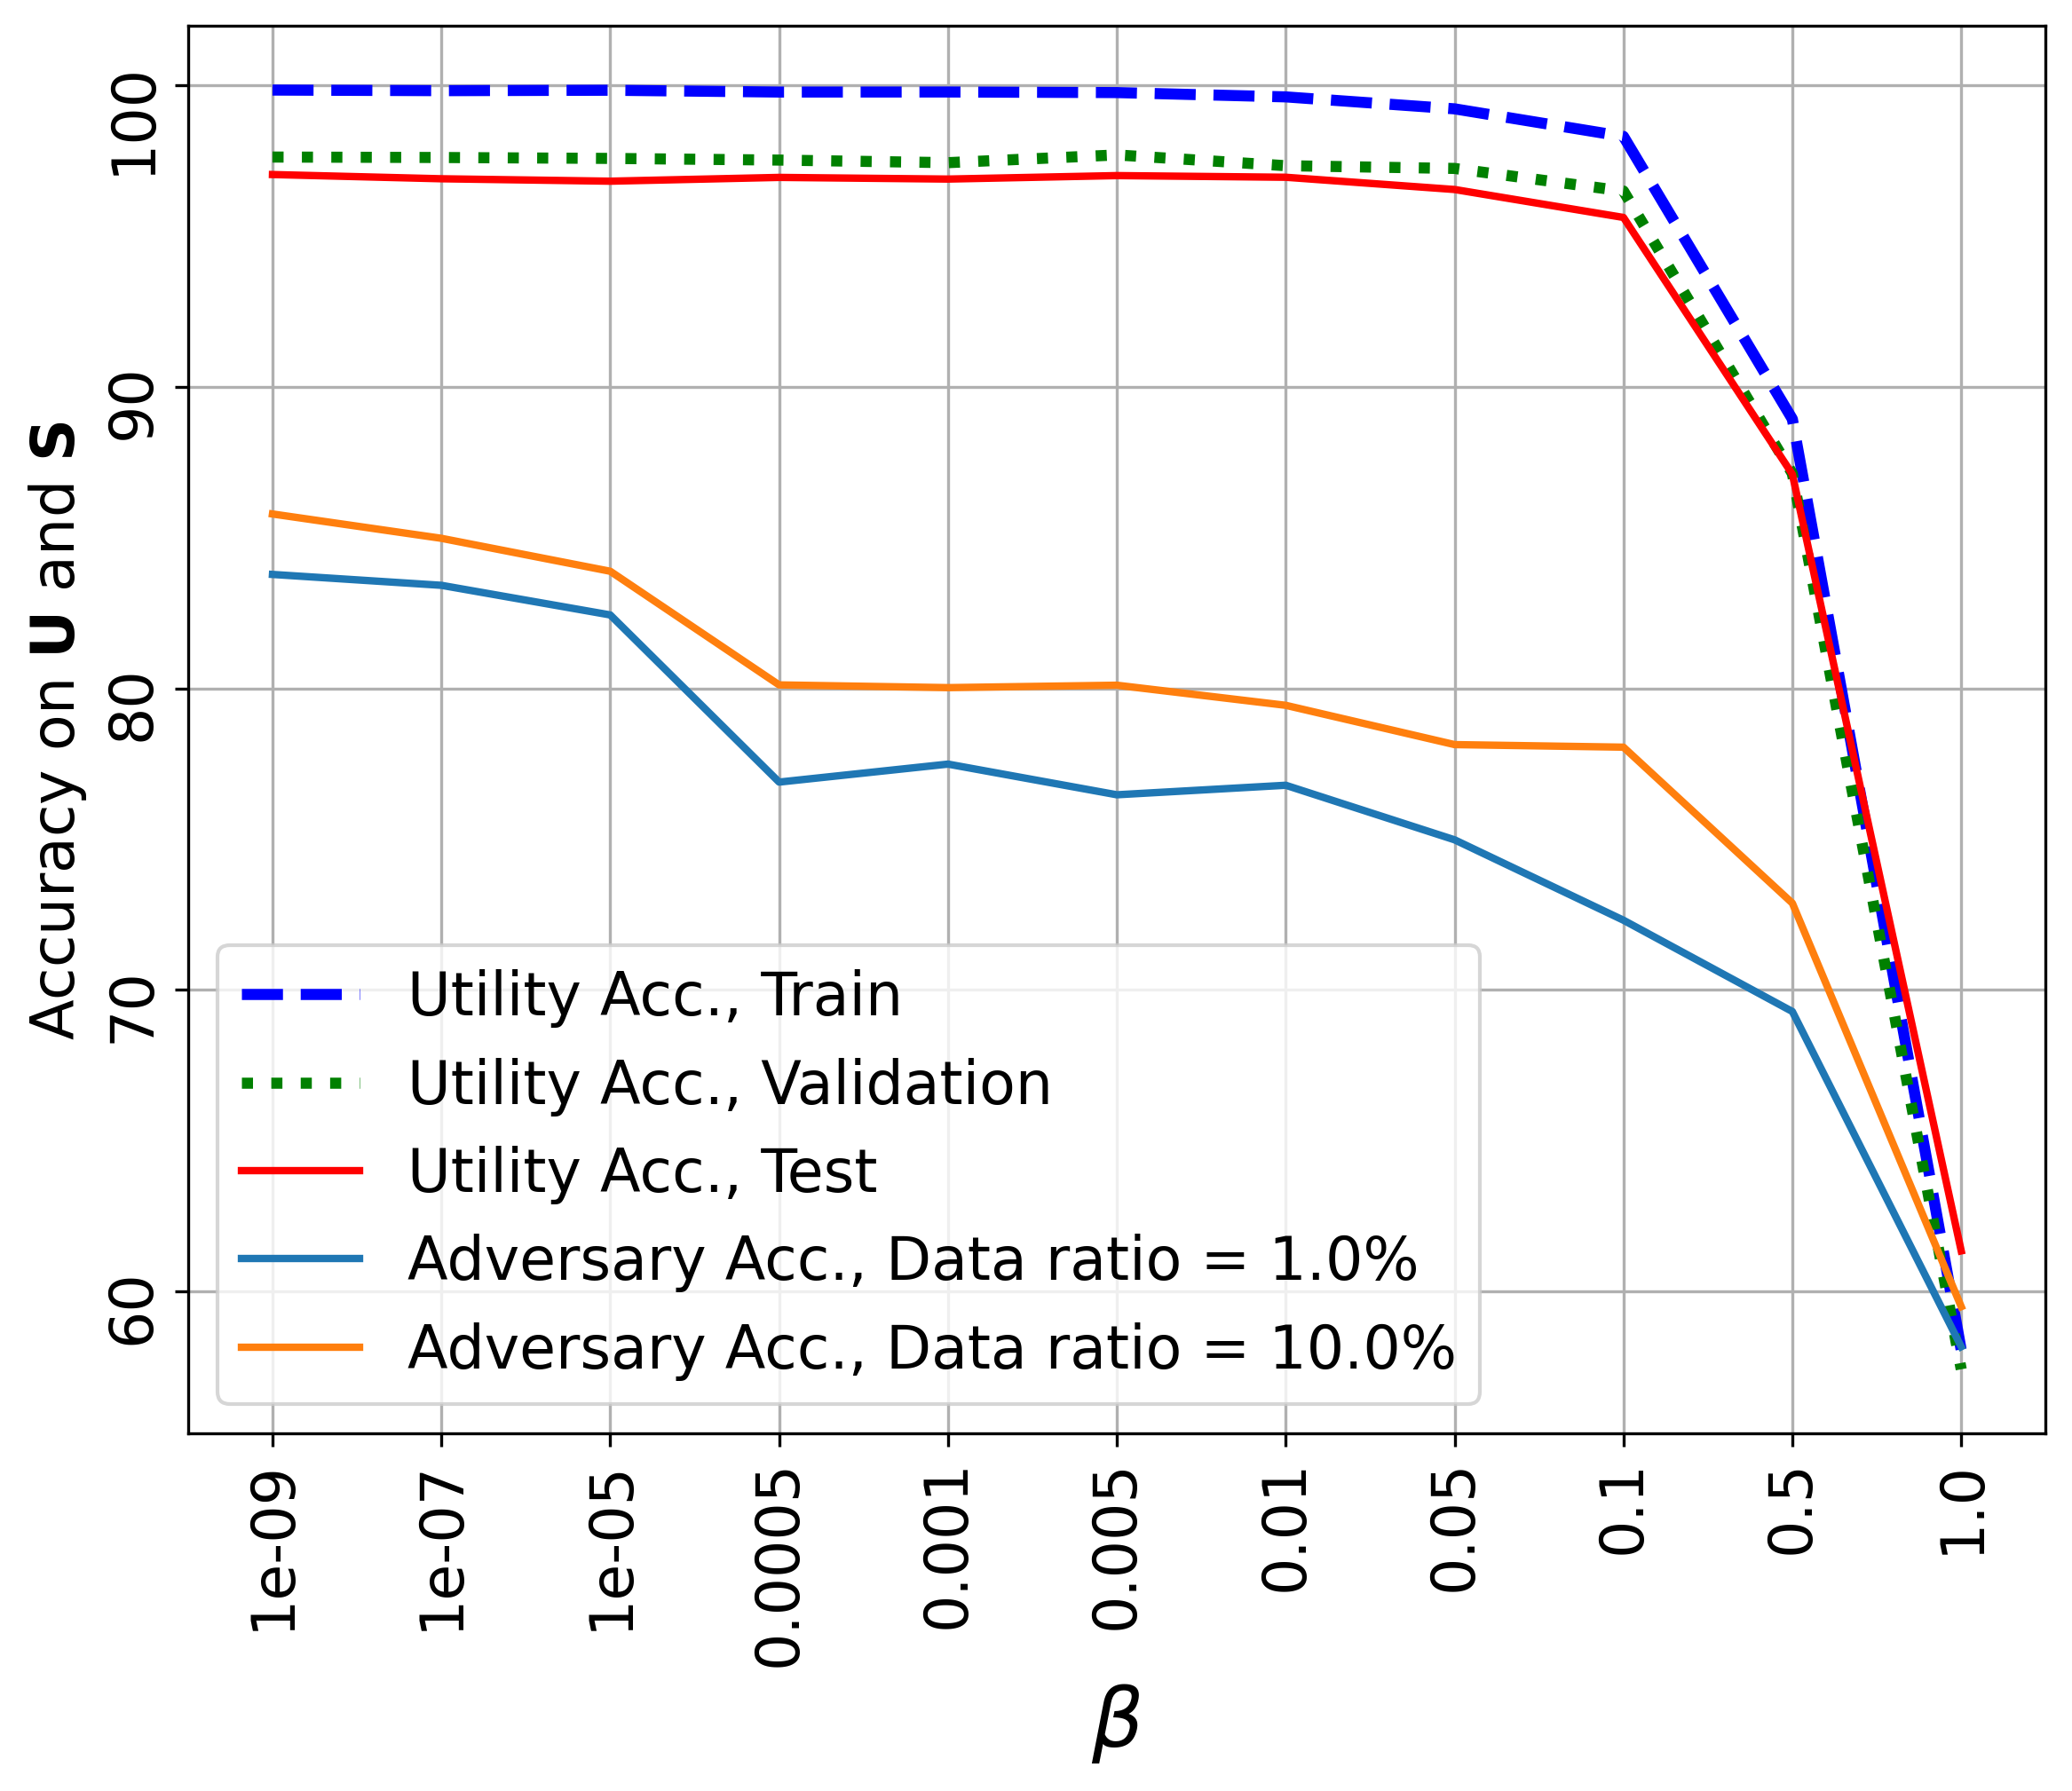

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


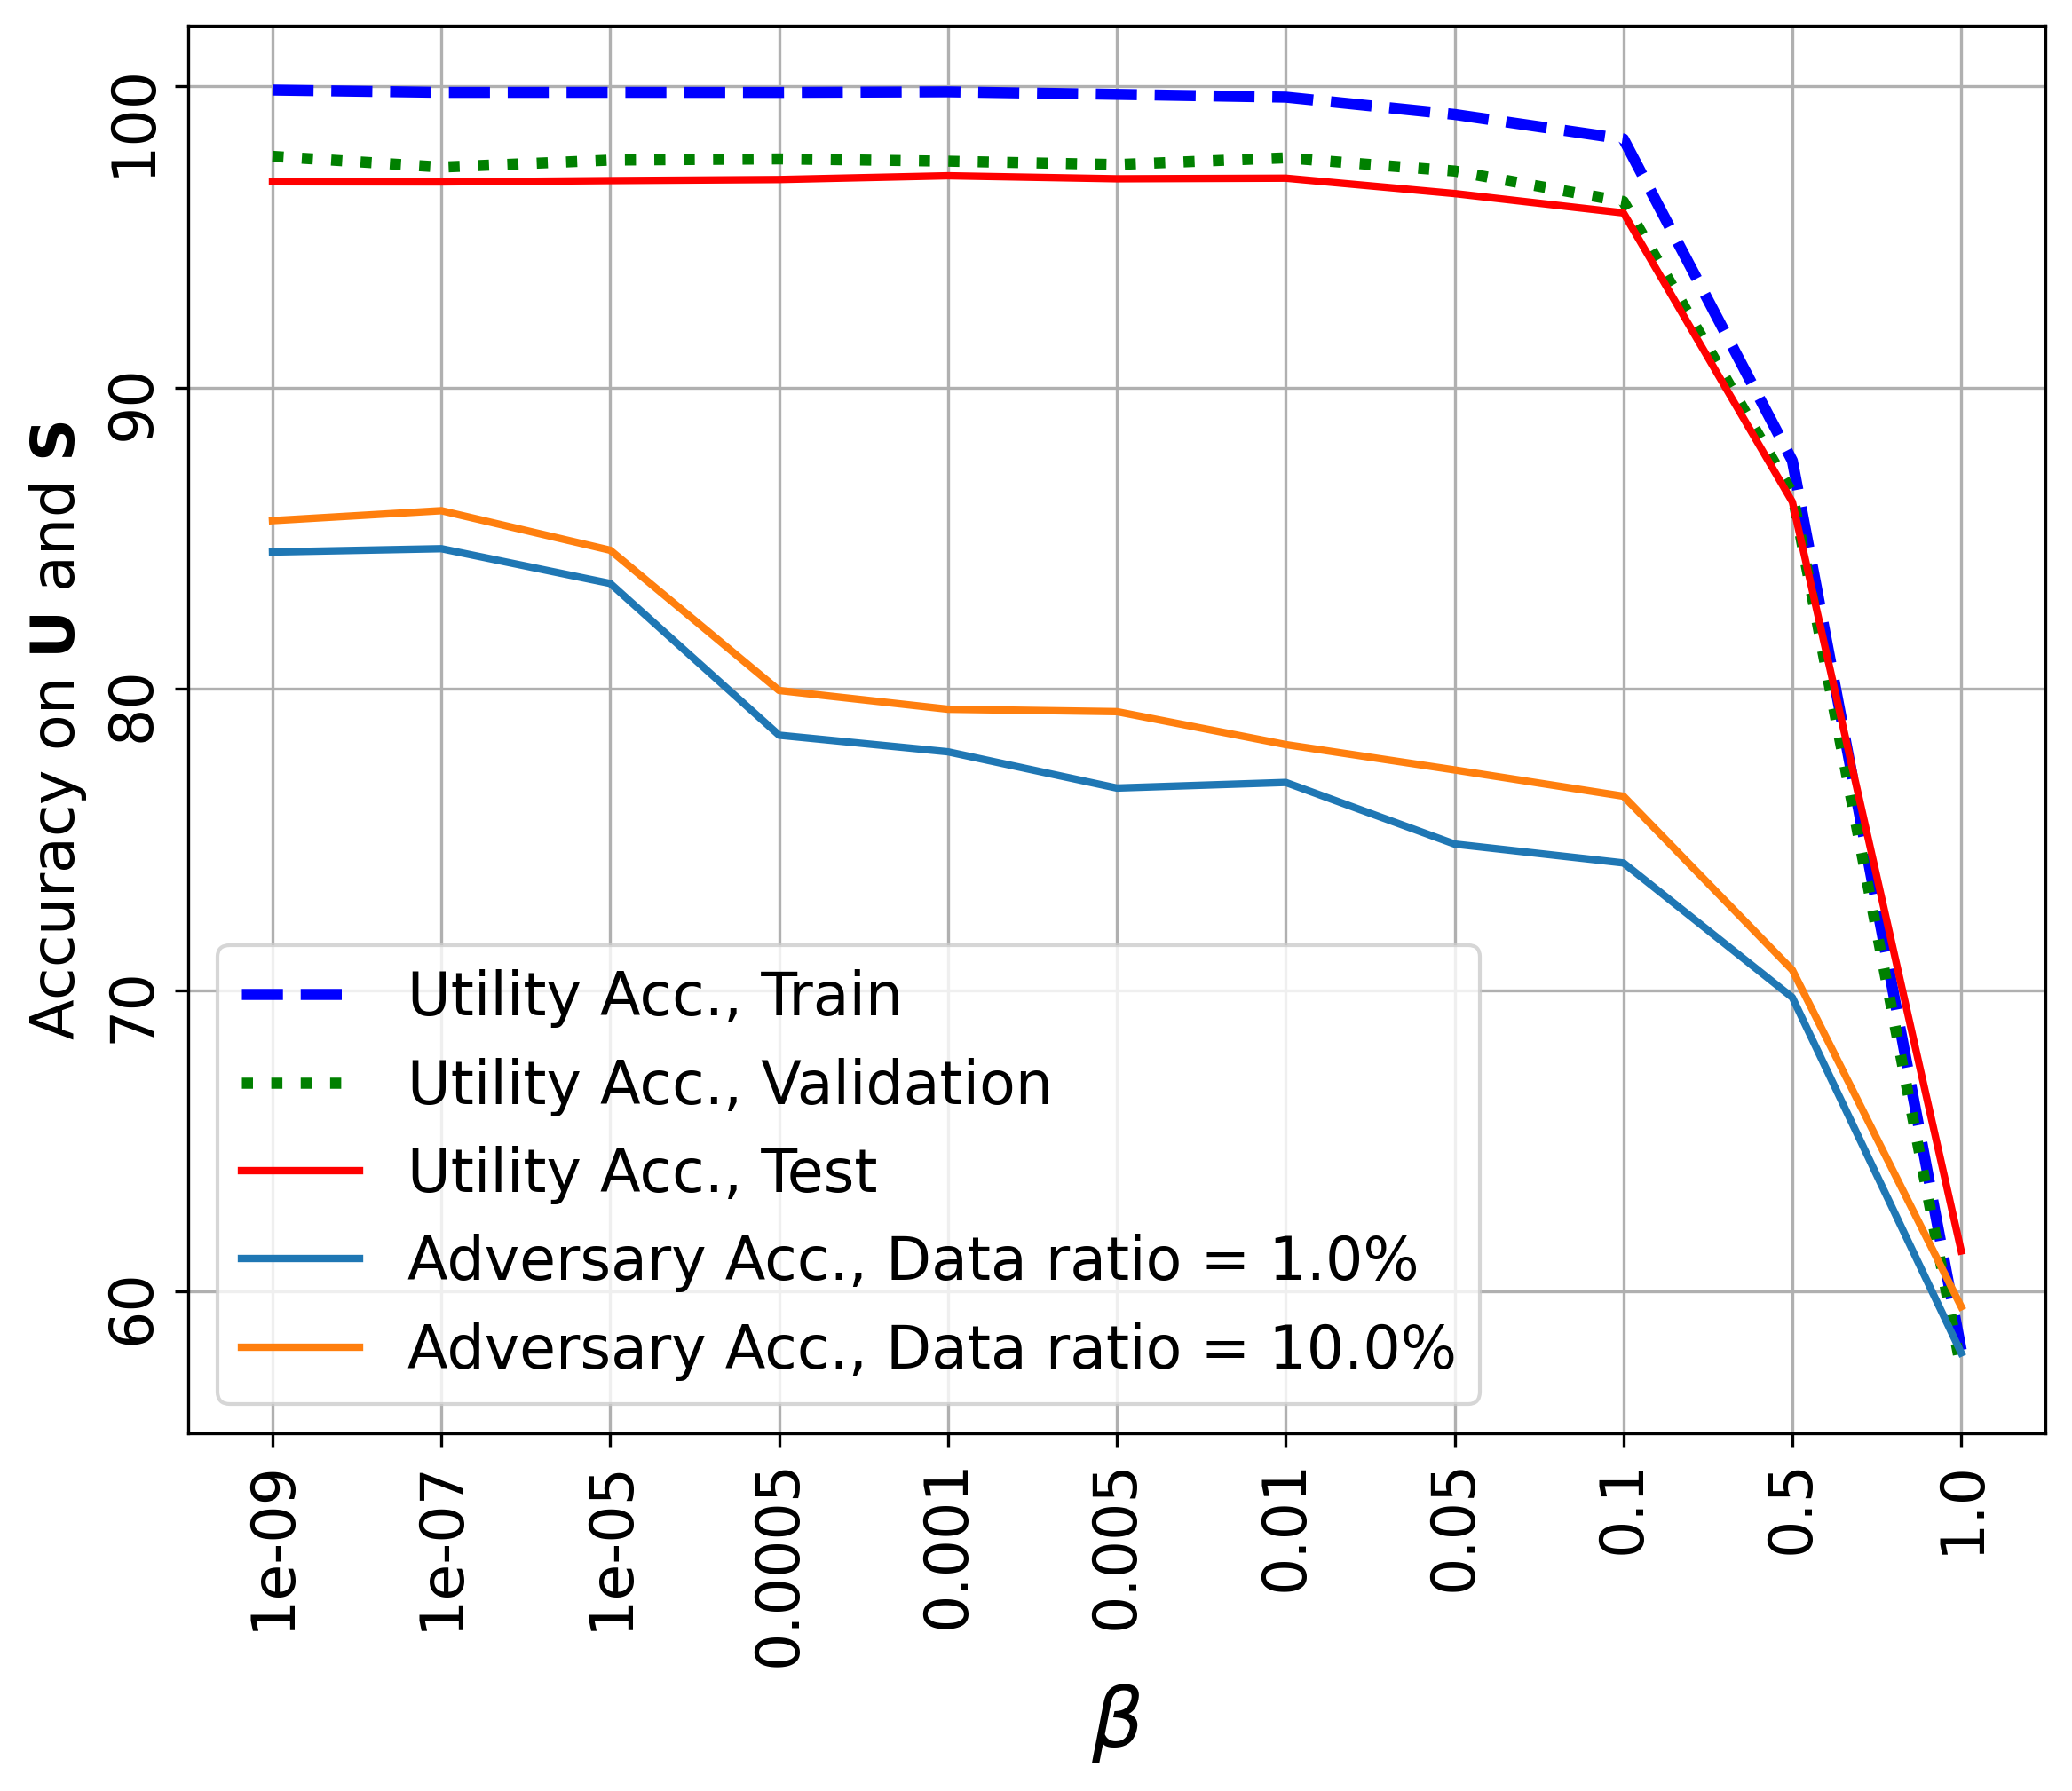

In [39]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
linestyles = ['-', '--', '-.', ':']
for i in range(util_acc_ts.shape[0]):
    plt.figure(figsize=(9,7))
    plt.title(r'Accuracy with $\beta$ $\in$ [10e-9 1.0] ' + f'{exp_info}_d={DIM_Z[i]}', fontsize=16)
    plt.plot(util_acc_tr[i], label='Utility Acc., Train', linestyle=linestyles[1], c='b', linewidth=3)
    plt.plot(util_acc_va[i], label='Utility Acc., Validation', linestyle=linestyles[3], c='g', linewidth=3)
    plt.plot(util_acc_ts[i], label='Utility Acc., Test', linestyle=linestyles[0], c='r', linewidth=2)
    for j in range(len(s_data_ratio)):
        plt.plot(sens_acc_ts[i,:,j], label=f'Adversary Acc., Data ratio = {s_data_ratio[j]*100}%', linestyle='-', linewidth=2)
        
    plt.legend()
    plt.grid()
    plt.xticks(list(range(len(beta_list))), beta_list)
    plt.tick_params(labelrotation=90)
    plt.xlabel(r'$\beta$', fontsize=22)
    plt.ylabel(r'Accuracy on $\mathbf{U}$ and $\mathbf{S}$', fontsize=16)
    plt.savefig(f'./saved_figures/chart_celeba_acc_{exp_info}_d_{DIM_Z[i]}.eps', format='eps', bbox_inches='tight')
    plt.savefig(f'./saved_figures/chart_celeba_acc_{exp_info}_d_{DIM_Z[i]}.png', format='png', bbox_inches='tight')
    plt.show()

# Plot mutual information between Z and S

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


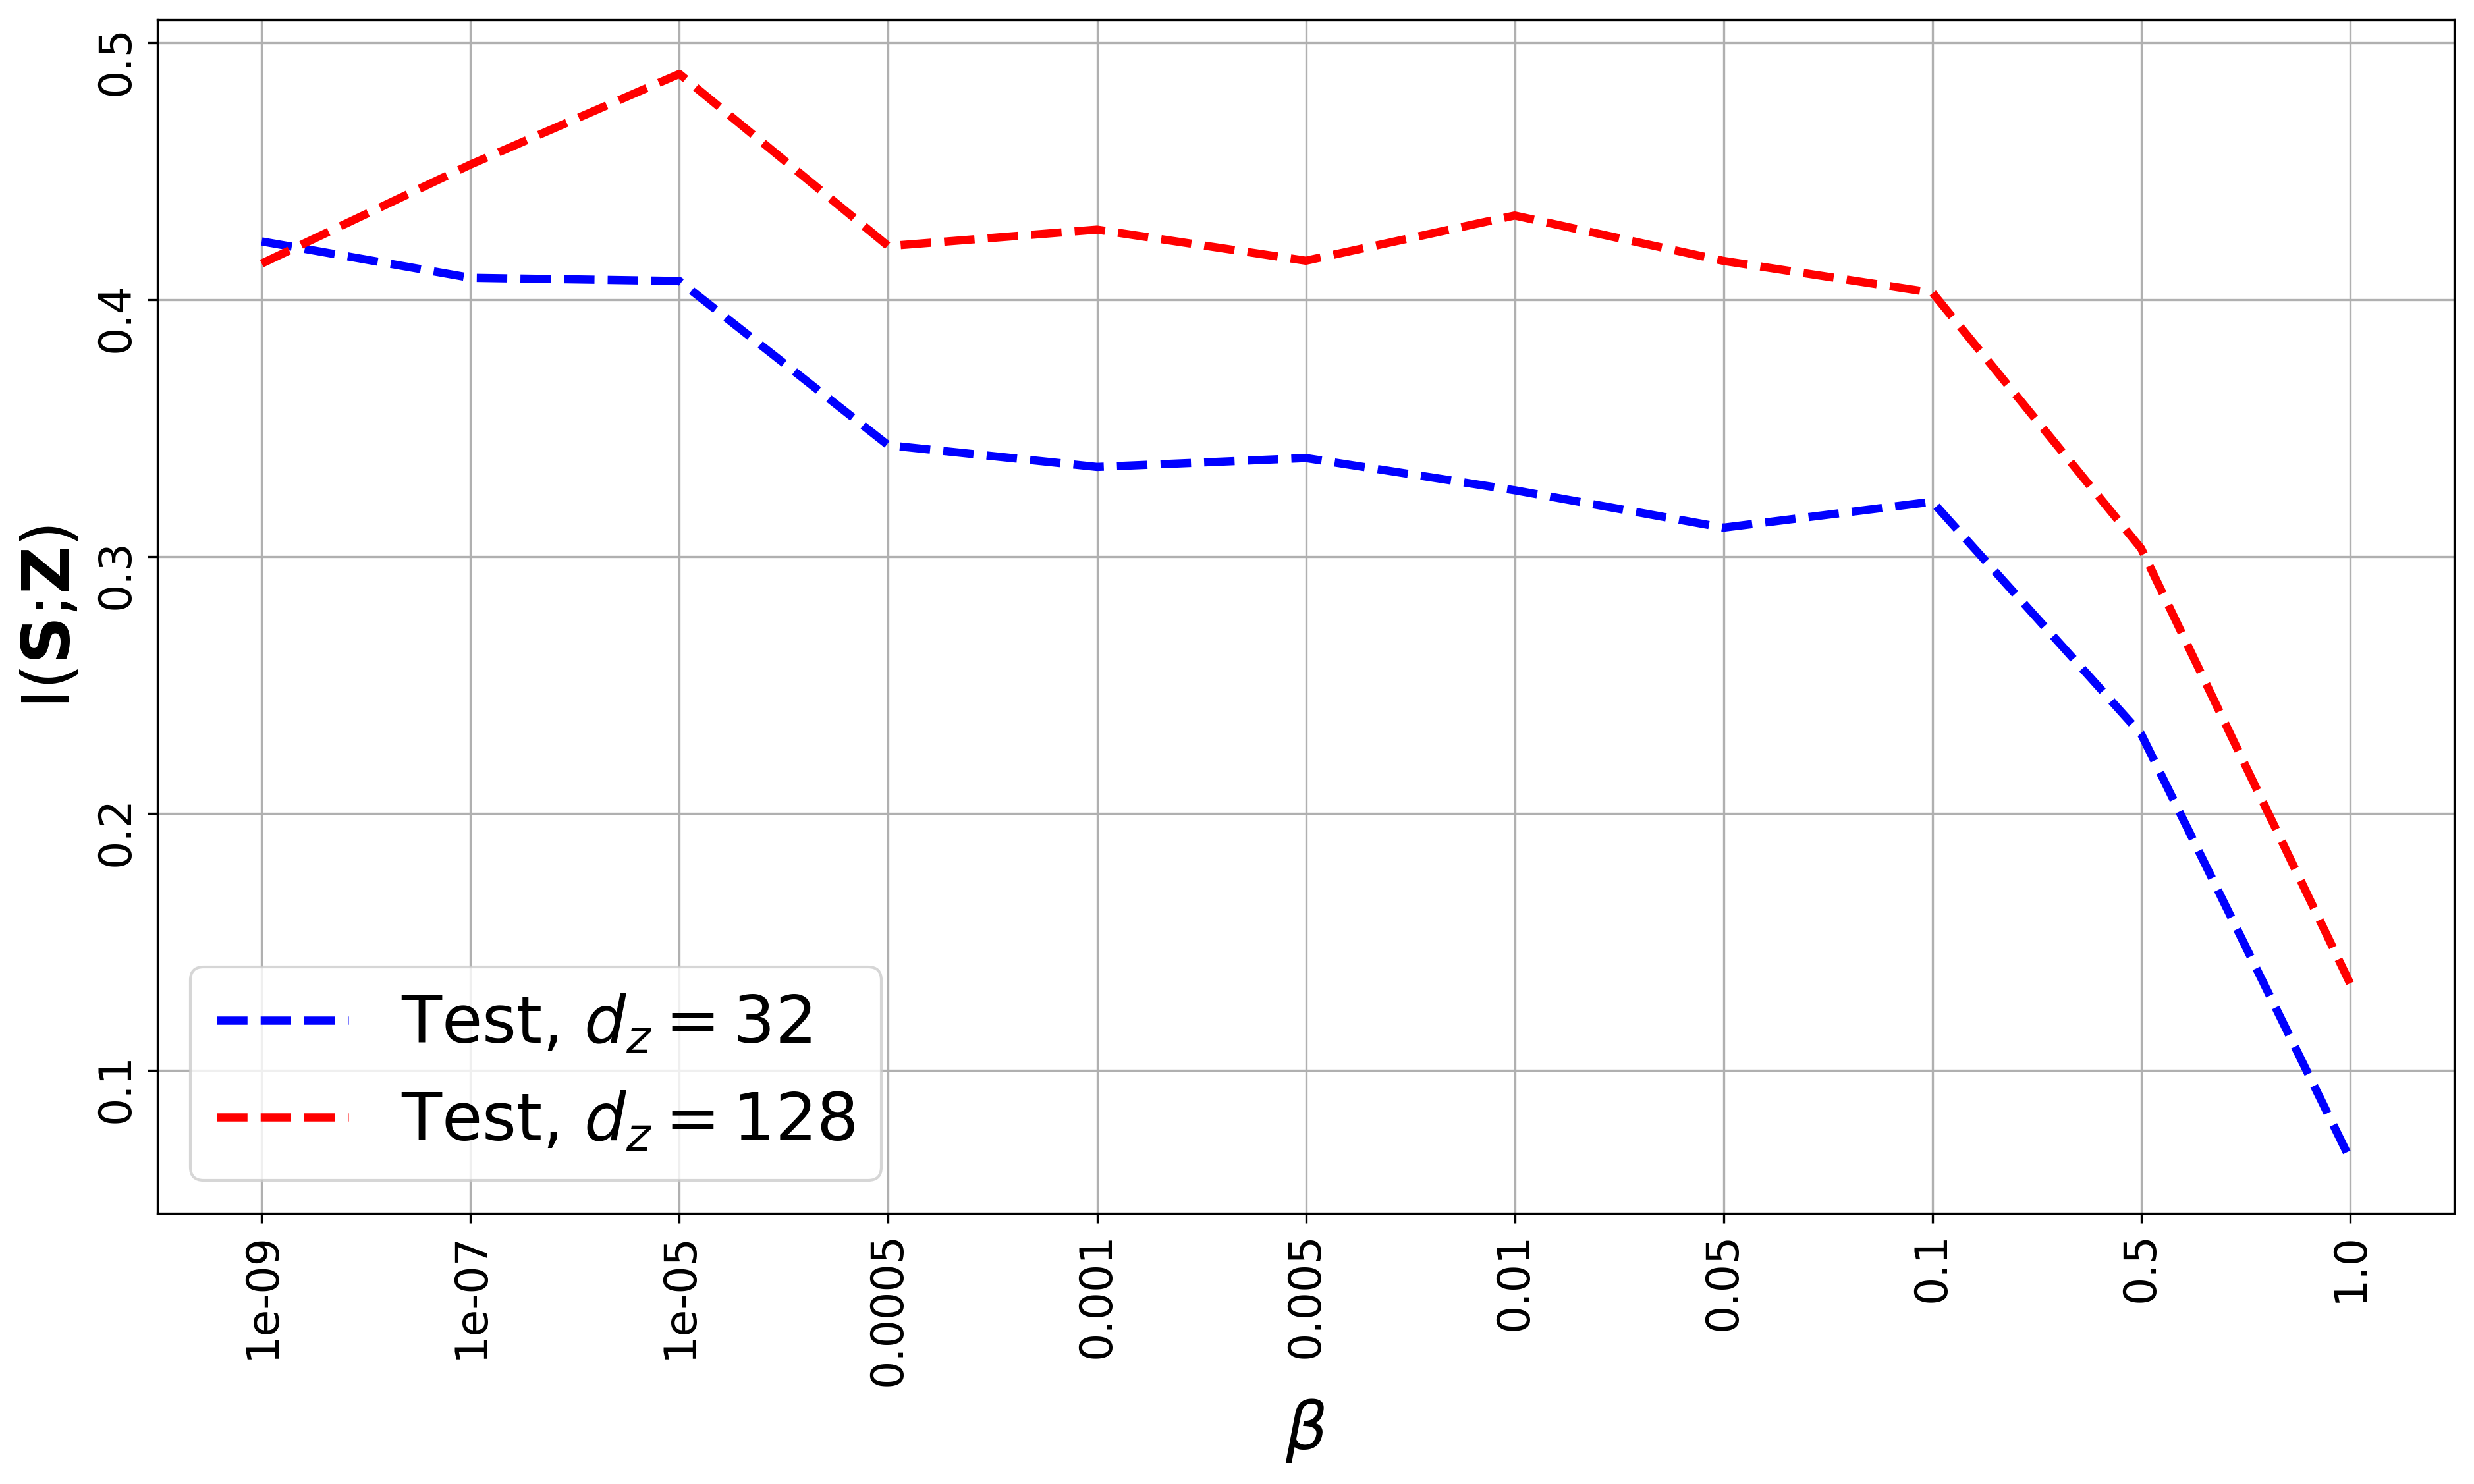

In [37]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(15,8))
plt.title(r'Mutual Information with $\beta$ $\in$ [10e-9 1.0]' + f' - {exp_info}', fontsize=20)
linestyles = ['-', '--', '-.', ':']
colors = ['b', 'r', 'g', 'c']
for i in range(mi_s.shape[0]):
    plt.plot(mi_s[i], label=f'Test, ' + r'$d_z=$' + f'{DIM_Z[i]}', linestyle=linestyles[1], c=colors[i%len(colors)] ,linewidth=3)
        
# plt.xscale('linear')
plt.xlabel(r'$\beta$', fontsize=24)
plt.xticks(list(range(len(beta_list))), beta_list)
plt.tick_params(labelrotation=90)

plt.ylabel(r'I($\mathbf{S}$;$\mathbf{Z}$)', fontsize=24)
plt.legend(prop={'size': 24})
plt.grid()
plt.savefig(f'./saved_figures/mi_zs_celeba_{exp_info}.eps', format='eps', bbox_inches='tight')
plt.savefig(f'./saved_figures/mi_zs_celeba_{exp_info}.png', format='png', bbox_inches='tight')
plt.show()

# Plot mutual information between Z and U

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


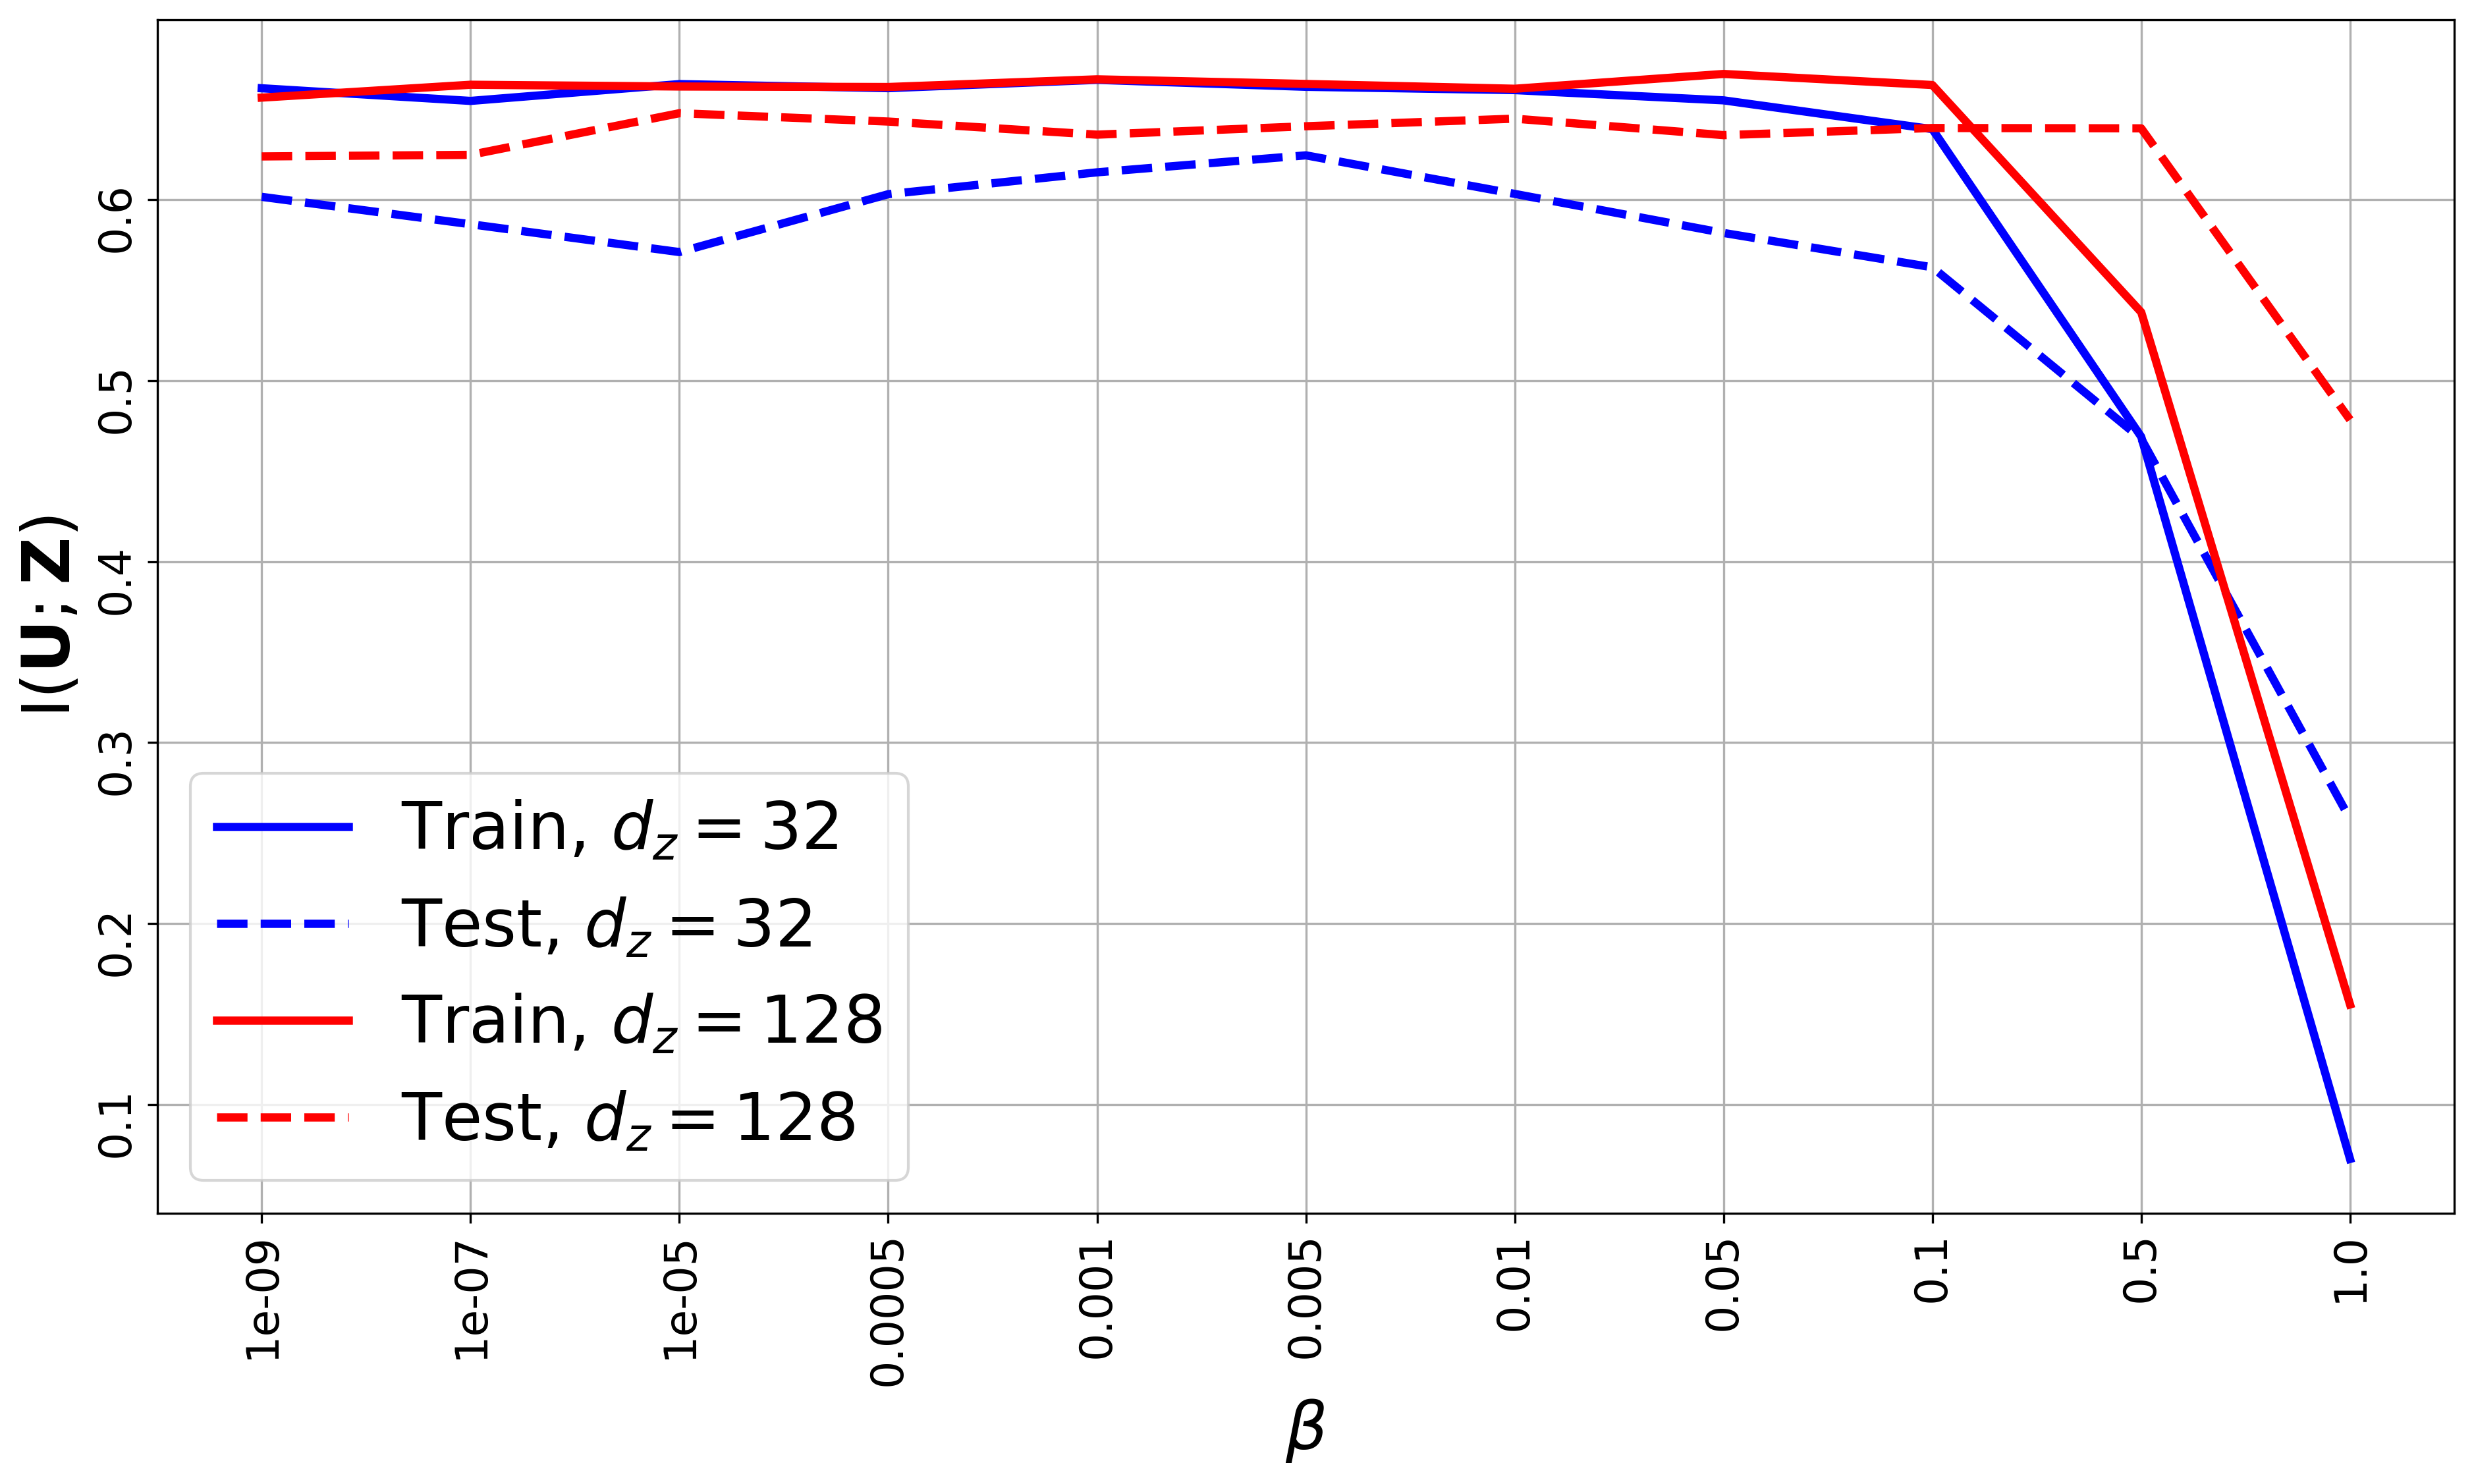

In [38]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(15,8))
linestyles = ['-', '--', '-.', ':']
colors = ['b', 'r', 'g', 'c']
plt.title(r'Mutual Information with $\beta$ $\in$ [10e-9 1.0]' + f' - {exp_info}', fontsize=20)
for i in range(mi_u_tr.shape[0]):
    plt.plot(mi_u_tr[i], label=f'Train, '+r'$d_z=$' + f'{DIM_Z[i]}', linestyle=linestyles[0],c=colors[i%len(colors)], linewidth=3)
    plt.plot(mi_u_ts[i], label=f'Test, ' +r'$d_z=$' + f'{DIM_Z[i]}', linestyle=linestyles[1],c=colors[i%len(colors)], linewidth=3)
        
# plt.xscale('linear')
plt.xlabel(r'$\beta$', fontsize=24)
plt.xticks(list(range(len(beta_list))), beta_list)
plt.tick_params(labelrotation=90)

plt.ylabel('I($\mathbf{U};\mathbf{Z}$)', fontsize=24)
plt.legend(prop={'size': 24})
plt.grid()
plt.savefig(f'./saved_figures/mi_zu_celeba_{exp_info}.eps', format='eps', bbox_inches='tight')
plt.savefig(f'./saved_figures/mi_zu_celeba_{exp_info}.png', format='png', bbox_inches='tight')
plt.show()

# Save results values to file

In [27]:
import scipy.io as sio
sio.savemat(f'./saved_data/acc_celeba_{exp_info}.mat', {'util_acc_ts':util_acc_ts, 'util_acc_va':util_acc_va, 'util_acc_tr':util_acc_tr, 'sens_acc_ts':sens_acc_ts})
sio.savemat(f'./saved_data/mi_celeba_{exp_info}.mat', {'mi_s':mi_s, 'mi_u_ts':mi_u_ts, 'mi_u_tr':mi_u_tr})

# Load results from file

In [ ]:
import scipy.io as sio
mat_contents  = sio.loadmat(f'./saved_data/acc_celeba_{exp_info}.mat')
util_acc_ts = mat_contents['util_acc_ts']
util_acc_va = mat_contents['util_acc_va']
util_acc_tr = mat_contents['util_acc_tr']
sens_acc_ts = mat_contents['sens_acc_ts']


mat_contents  = sio.loadmat(f'./saved_data/mi_celeba_{exp_info}.mat')
mi_s = mat_contents['mi_s']
mi_u_ts = mat_contents['mi_u_ts']
mi_u_tr = mat_contents['mi_u_tr']